# Case Study - Model Robustness

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Aim: How robust is my network to shifts in data

We often find ourselves in a situation where we have trained a model for a certain task. The network performs well on the training and validation data. It also performs good on the hold out test set. Still you wonder what happens when you feed it data that is systematically different from all three sets? Does it make sense to re-train with more extensive data augmentation?

In this case study we demonstrate how `misas` helps answer these questions with a concrete example:
 - **Model**: Custom U-Net
 - **Data**: Small set of transversal CMR images

## Prepare Model for `misas`

In [ ]:
from fastai.vision.all import *
from misas.core import default_cmap, default_cmap_true_mask
from misas.fastai_model import Fastai2_model

from PIL import Image, ImageEnhance, ImageShow, ImageOps
from matplotlib.pyplot import imshow
from functools import partial
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import gif
import math
import numpy as np
#import torchvision
import altair as alt
import warnings

In [ ]:
# model = Fastai1_model('example/b0','b0_transversal_5_5') # if it were local
trainedModel = Fastai2_model('chfc-cmi/transversal-cmr-seg', 'b0_transversal_5_5', force_reload=False)


Using cache found in /home/csa84mikl/.cache/torch/hub/chfc-cmi_transversal-cmr-seg_master


## Prepare Dataset for `misas`

Data is available as png images and masks which is just fine for `misas`

(128, 128)

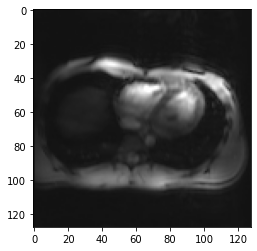

In [ ]:
img = Image.open("example/b0/images/train_example.png").convert("RGB")
plt.imshow(img)
img.size

## How does the trained model perform on this (training) example?

Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


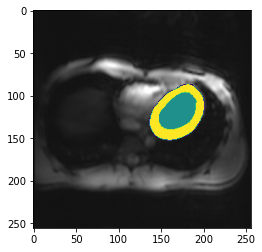

In [ ]:
img = trainedModel.prepareSize(img)
fig,ax = plt.subplots(figsize=(4,4))
plt.imshow(img)
plt.imshow(trainedModel.predict(img),cmap=default_cmap)

So how does it perform on validation data?

In [ ]:
from misas.core import default_cmap

In [ ]:
from glob import glob
files = sorted(glob("example/b0/images/val*.png"))

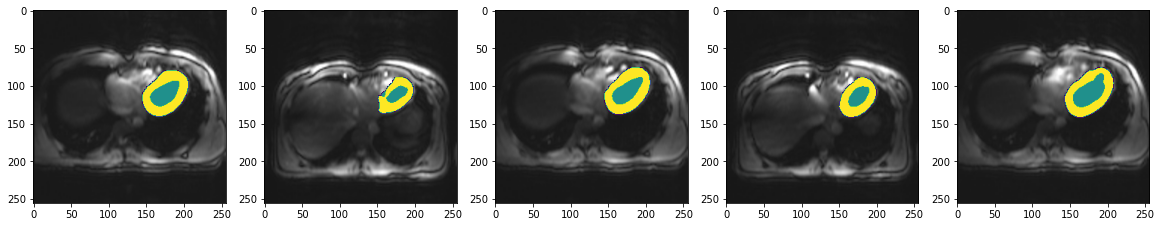

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    fname = files[i]
    tmp = trainedModel.prepareSize(Image.open(fname).convert("RGB"))
    ax.imshow(tmp)
    ax.imshow(trainedModel.predict(tmp), cmap=default_cmap)

This is not great. But given the limited training data it looks decent. So let's have a closer look on how robust this model is. In particular to differences we might encounter when applying this network to new data. 

## Robustness to basic transformations

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from misas.core import *

In [ ]:
img = lambda: Image.open(files[0]).resize((256,256)).convert("RGB")
trueMask = lambda: Image.open(files[0].replace("image","mask")).convert("I")

### Sensitivity to orientation

Changes in orientation are very common. Not because it is common to acquire images in different orientation but because the way data is stored in different file formats like nifti and dicom differs. So it is interesting to see how the model works in all possible orientations (including flips).

  0%|          | 0/8 [00:00<?, ?it/s]

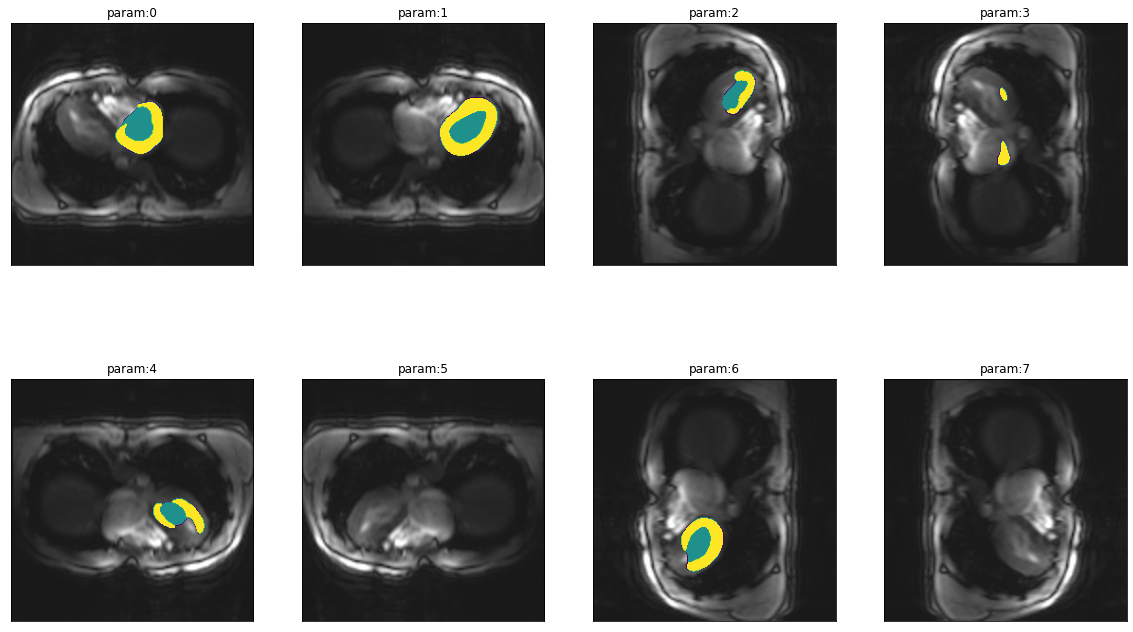

In [ ]:
plot_series(get_dihedral_series(img(),trainedModel), nrow=2, figsize=(20,12))

In [ ]:
results = eval_dihedral_series(img(),trueMask(),trainedModel,components=["bg","LV","MY"])

  0%|          | 0/8 [00:00<?, ?it/s]

Not surprisingly, the model is very sensitive to changes in orientation. So when using this model it is very important to feed the images in the proper orientation.

Another really interesting thing is happening, for parameters 2 and 3 (top row, right) a heart shaped mask is drawn in the right side of the image. However, these images are flipped so the shape is actually in the wrong side of the torax. This gives a strong indication that the location within the image is one of the features the network has learned.
Depending on your use case this might indeed be a sensible feature to use for segmentation of the heart as in a huge majority of cases the left ventricle of the heart is on the left side of the chest (so showing up on the right side in transversal slices).

### Sensitivity to rotation

There should not be a huge variation in rotation (by small angles) when working with transversal slices. Still it is a good idea to get an impression of how quickly segmentation performance decreases with deviations in rotation.

  0%|          | 0/12 [00:00<?, ?it/s]

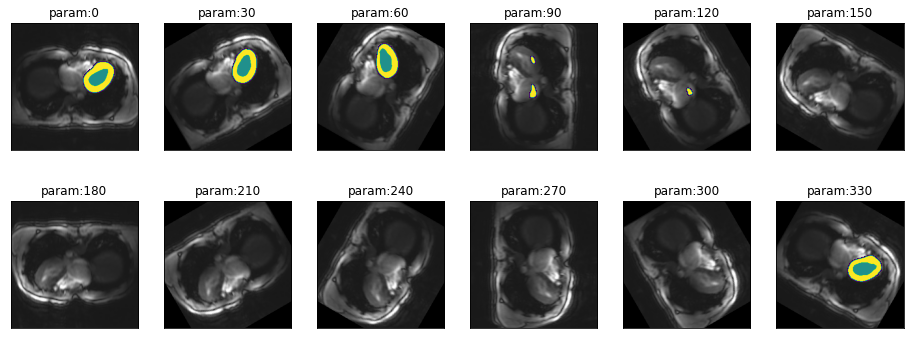

In [ ]:
plot_series(get_rotation_series(img(),trainedModel, step=30), nrow=2)

In [ ]:
results = eval_rotation_series(img(),trueMask(),trainedModel,start=-180,end=180,components=["bg","LV","MY"])

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
import altair as alt

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x=alt.X("deg",axis=alt.Axis(title=None)),
     y=alt.Y("value",axis=alt.Axis(title=None)),
     color=alt.Color("variable",legend=None),
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

So there is quite a range (from -40 to 80 degrees) where prediction performance remains stable. This is sufficient not to worry about minor deviations.

Let's have another look at the network moving to the wrong side of thorax when predicting on rotated images:

In [ ]:
gif_series(
    get_rotation_series(img(),trainedModel, start=1, end=360,step=10),
    "example/b0/rotation.gif",
    param_name="deg",
    duration=400
)

  0%|          | 0/36 [00:00<?, ?it/s]

![segmentation sensitivity to rotation](example/b0/rotation.gif)

### Sensitivity to cropping

Another variation that might occur in real life is a difference in field of view. This can happen due to different settings when acquiring the images or due to pre-processing steps in an analysis pipeline.

  0%|          | 0/6 [00:00<?, ?it/s]

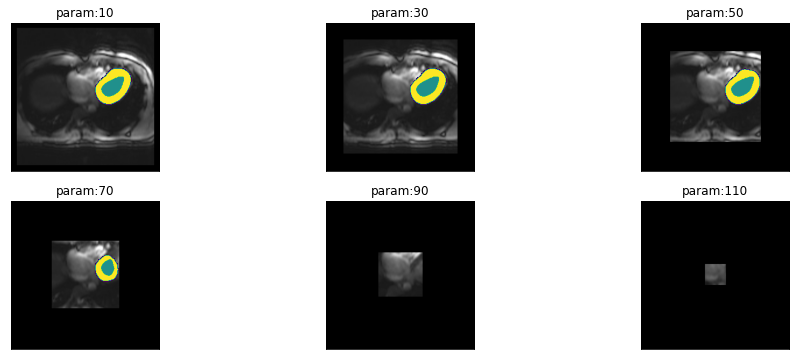

In [ ]:
plot_series(get_crop_series(img(),trainedModel, start = 10, end = 120, step = 20), nrow=2)

In [ ]:
gif_series(
    get_crop_series(img(),trainedModel, start=120, end=10,step=-10),
    "example/b0/crop.gif",
    param_name="pixels",
    duration=400
)

  0%|          | 0/11 [00:00<?, ?it/s]

![segmentation sensitivity to rotation](example/b0/crop.gif)

This looks quite good. It seems to be okay to crop the image as long as the whole heart remains intact. As soon as we start to crop part of the heart the model is no longer able to find it (this is expected). It also does not start to predict heart somewhere, where it should not when cropping even further.

In [ ]:
results = eval_crop_series(img(),trueMask(),trainedModel,start = 5, components=["bg","LV","MY"])

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

The dice scores of 1 for very small sizes is because the model is not supposed to predict anything and it is not predicting anything. It drops to 0 when the heart starts to appear on the image but the model is still unable to locate it and then raises to the final performance it has on the whole image. Reaching a plateau at a size of 160px.

### Sensitivity to brightness

  0%|          | 0/11 [00:00<?, ?it/s]

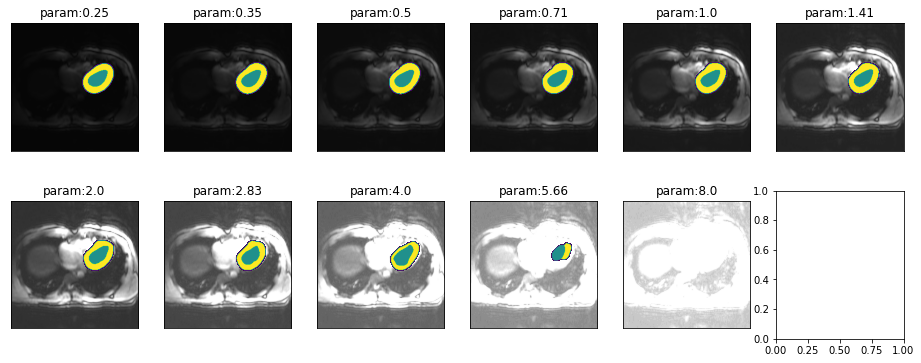

In [ ]:
plot_series(get_brightness_series(img(),trainedModel), nrow=2)

In [ ]:
results = eval_bright_series(img(),trueMask(),trainedModel, components=["bg","LV","MY"])

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to contrast

  0%|          | 0/11 [00:00<?, ?it/s]

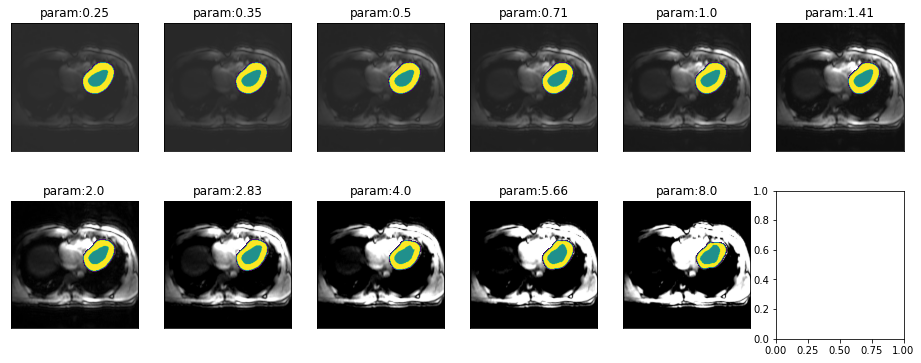

In [ ]:
plot_series(get_contrast_series(img(),trainedModel), nrow = 2)

In [ ]:
results = eval_contrast_series(img(),trueMask(),trainedModel, components=["bg","LV","MY"])

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to zoom

  0%|          | 0/10 [00:00<?, ?it/s]

(None,)

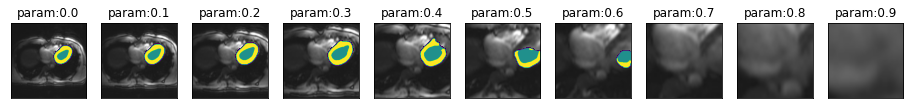

In [ ]:
plot_series(get_zoom_series(img(),trainedModel)),#end=600,step=60))

In [ ]:
results = eval_zoom_series(img(),trueMask(),trainedModel,components=["bg","LV","MY"])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_zoom_series(img(),trainedModel),
    "example/b0/zoom.gif",
    param_name="scale",
    duration=400
)

  0%|          | 0/10 [00:00<?, ?it/s]

![segmentation sensitivity to zoom](example/b0/zoom.gif)

## Robustness to MR artifacts

### Spike artifact

Spike artifacts can happen with different intensities and at different locations in k-space. It is even possible to have multiple spikes. 

In [ ]:
from misas.mri import *

First we consider a single spike quite far from the center of k-space.

  0%|          | 0/5 [00:00<?, ?it/s]

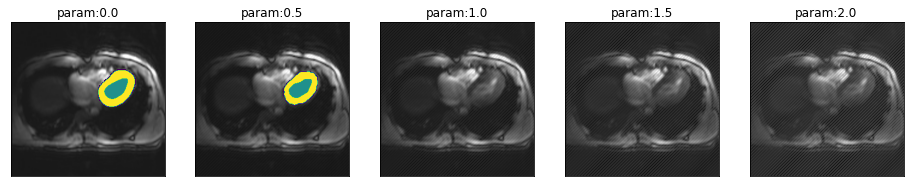

In [ ]:
plot_series(get_spike_series(img(),trainedModel))

Segmentation performance is heavily impacted by this kind of artifact. The training examples did not have a single example with this *herringbone* pattern so we even get striped predictions for the myocardium.

Let's have a look how the location of the spike in k-space changes the artifact and model performance. From top to bottom, moving farter from the center.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

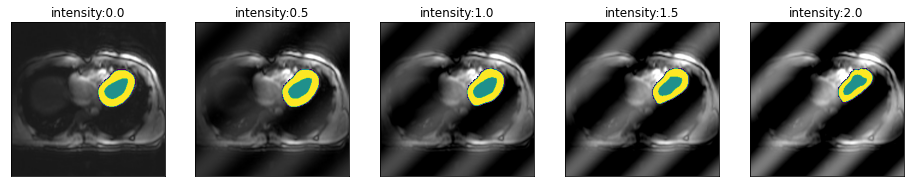

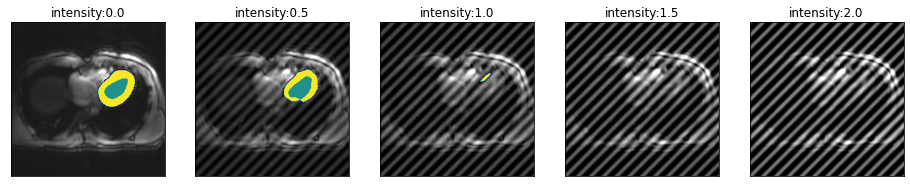

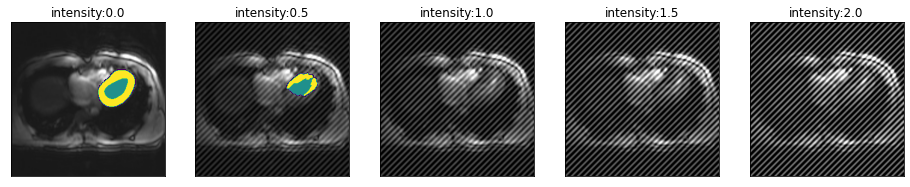

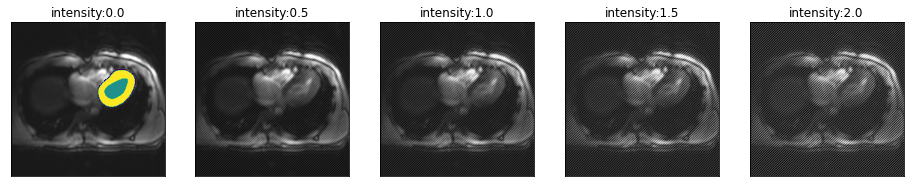

In [ ]:
for i in [.51,.55,.6,.75]:
    plot_series(get_spike_series(img(),trainedModel,spikePosition=[i,i]), param_name="intensity")

So spikes closer to the center of k-space create artifacts with lower frequency and have less severe impact on segmentation performance.

So far we only looked at spikes on the diagonal of k-space, for the sake of completeness we can also look at arbitrary locations in k-space.

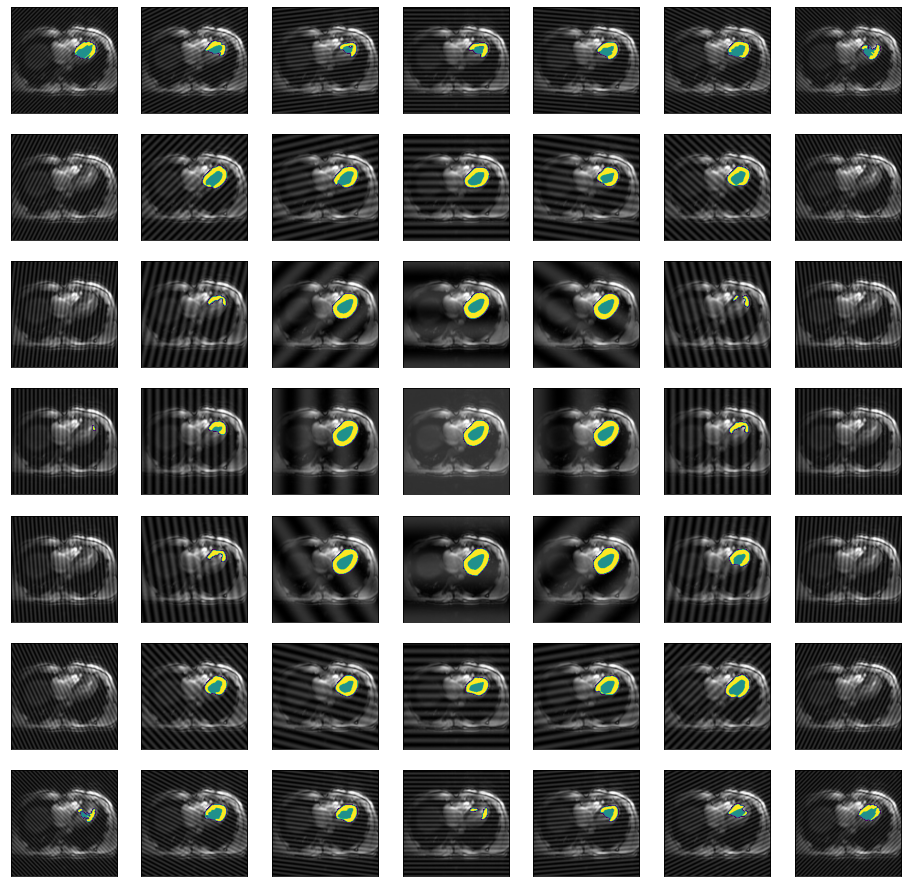

In [ ]:
fig, axs = plt.subplots(7,7,figsize=(16,16))
values = [.4,.45,.49,.5,.51,.55,.6]
values=list(itertools.product(values, values))
for x, ax in zip(values, axs.flatten()):
    im = img()
    im = spikeTransform(im,.5,list(x))
    ax.imshow(np.array(im))
    ax.imshow(np.array(trainedModel.predict(im)), cmap=default_cmap)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

### $B_0$-Field inhomogeneity 

$B_0$-Field inhomogeneieties are quite common, particularly at higher field strength. Adjusting these inhomogeneities at ultra high field strength (shimming) is an active field of research (Hock et al. 2020). So what is the impact of this so-called Bias field:

  0%|          | 0/3 [00:00<?, ?it/s]

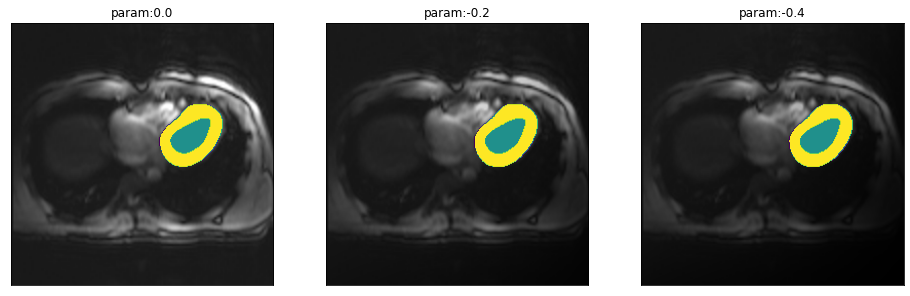

In [ ]:
plot_series(get_biasfield_series(img(),trainedModel))

The model works (at least on this example) reliably for even very intense field inhomogeneities.